In [ ]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/ROBUST_TIME SERIES_CLASSIFICATION/AnomalyBERT-main

/content/gdrive/MyDrive/ROBUST_TIME SERIES_CLASSIFICATION/AnomalyBERT-main


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
# Training loop
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_curve, auc
from torch.nn.utils.rnn import pad_sequence


In [ ]:
#!pip install copulas
!pip install pyvinecopulib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.7 MB/s eta 0:00:00


In [ ]:
data_norm_anom = pd.read_csv('/content/gdrive/MyDrive/DATASETS/TIME_SERIES_MULTI_V_DATA/SWAT_NORMALIZED.csv')
data_norm_anom = data_norm_anom.iloc[0:100000]
data_norm_anom = data_norm_anom.dropna()

df_normal = data_norm_anom[data_norm_anom['Label'] == 0]
df_normal = df_normal.iloc[:, 0:-1]
df_normal.shape

(93873, 26)

In [ ]:
df_anomaly.shape[1]

NameError: name 'df_anomaly' is not defined

In [ ]:
data_norm_anom = pd.read_csv('/content/gdrive/MyDrive/DATASETS/TIME_SERIES_MULTI_V_DATA/SWAT_NORMALIZED.csv')
data_norm_anom = data_norm_anom.iloc[0:20000]
data_norm_anom = data_norm_anom.dropna()

df_anomaly = data_norm_anom[data_norm_anom['Label'] == 1]
df_anomaly = df_anomaly.iloc[:, 0:-1]
df_anomaly.shape

(4466, 26)

In [ ]:
df_anomaly = df_anomaly.values
df_anomaly.shape

(4466, 26)

In [ ]:
df_normal = df_normal.values
df_normal.shape

(93873, 26)

In [ ]:
import numpy as np
import random

class SyntheticAnomalyGenerator:
    def __init__(self,
                 window_size,
                 reference_anomalies,
                 anomaly_types=['local_perturbation']):
        """
        Initializes the anomaly generator that oversamples real anomaly data
        but applies small perturbations to create a local neighborhood around
        the real anomalies.

        Args:
            window_size (int): The size of the anomaly window to inject.
            reference_anomalies (np.ndarray): Real anomaly data from which to oversample.
              Shape could be (num_anomalies, sequence_length, num_features) or
              (num_anomalies, num_features) if each row is a snippet, etc.
            anomaly_types (list): We keep it flexible, but default to ['local_perturbation'].
        """
        self.anomaly_types = anomaly_types
        self.window_size = window_size

        # Real anomaly data to oversample from
        self.reference_anomalies = reference_anomalies

    def inject_anomaly_into_sequence(self, sequence):
        """
        Called externally to inject an anomaly into 'sequence' by
        picking a real anomaly snippet, perturbing it, and overlaying.
        """
        anomalous_sequence = sequence.copy()
        anomaly_type = random.choice(self.anomaly_types)

        seq_length, num_features = anomalous_sequence.shape

        if seq_length <= self.window_size:
            t0 = 0
            t1 = seq_length
        else:
            t0 = random.randint(0, seq_length - self.window_size)
            t1 = t0 + self.window_size

        if anomaly_type == 'local_perturbation':
            anomalous_sequence = self.local_perturbation_injection(anomalous_sequence, t0, t1)
        elif anomaly_type == 'permutation_anomaly':
            # optional, if you want partial permutations
            anomalous_sequence = self.permutation_anomaly(anomalous_sequence, t0, t1)

        return anomalous_sequence

    def local_perturbation_injection(self, sequence, t0, t1):
        """
        1) Randomly pick a real anomaly snippet from reference_anomalies.
        2) Possibly adapt or clamp it to 'window_size'.
        3) Add small random perturbations (noise, slight scaling, partial permutations, etc.).
        4) Overlay onto 'sequence[t0:t1]'.
        """
        anomalous_sequence = sequence.copy()
        window_length = t1 - t0
        seq_length, num_features = anomalous_sequence.shape

        # 1) pick a random anomaly snippet from reference_anomalies
        #    Suppose reference_anomalies has shape (num_anomalies, anomaly_length, num_features)
        #    or (num_anomalies, num_features) if each row is a snippet.
        rand_idx = random.randint(0, self.reference_anomalies.shape[0]-1)
        real_anomaly_snippet = self.reference_anomalies[rand_idx]

        # Check if real_anomaly_snippet is 2D or 1D
        if real_anomaly_snippet.ndim == 1:
            # shape (num_features,) => we replicate or clamp it
            # e.g. we'll just tile it for 'window_length'
            real_anomaly_snippet = np.tile(real_anomaly_snippet, (window_length,1))
        elif real_anomaly_snippet.shape[0] != window_length:
            # We do a clamp or pad approach:
            real_len = real_anomaly_snippet.shape[0]
            if real_len > window_length:
                # clamp
                start_ = random.randint(0, real_len - window_length)
                real_anomaly_snippet = real_anomaly_snippet[start_:start_+window_length, :]
            else:
                # if real_len < window_length => pad repeats or edge
                repeats_needed = window_length - real_len
                # simplest => tile or pad
                real_anomaly_snippet = np.concatenate([
                    real_anomaly_snippet,
                    np.tile(real_anomaly_snippet[-1,:], (repeats_needed,1))
                ], axis=0)

        # Now real_anomaly_snippet is shape (window_length, num_features)

        # 2) Add small perturbations
        perturbed_snippet = self.apply_small_perturbations(real_anomaly_snippet)

        # 3) Overlay
        anomalous_sequence[t0:t1] = perturbed_snippet
        return anomalous_sequence

    def apply_small_perturbations(self, snippet):
        """
        snippet shape: (window_length, num_features)
        We'll do e.g.:
          - small gaussian noise
          - slight random scaling per feature
          - partial permutations of a few rows (rare)
        all to keep changes mild.
        """
        w_len, n_feats = snippet.shape
        snippet_ = snippet.copy()

        # A) small gaussian noise
        noise_std = 0.05 * np.std(snippet_)  # e.g. 5% of snippet's std
        noise = np.random.normal(0, noise_std, snippet_.shape)
        snippet_ += noise

        # B) slight random scaling per feature
        # e.g. each feature f => scale_f in [0.95,1.05]
        scales = 0.95 + 0.1*np.random.rand(n_feats)
        for f in range(n_feats):
            snippet_[:, f] *= scales[f]

        # C) partial row permutation, only a few rows
        # e.g. we permute 10% of the snippet rows:
        row_count = int(0.1 * w_len)  # 10% of rows
        if row_count>1:
            perm_indices = np.random.choice(w_len, size=row_count, replace=False)
            # shuffle those rows
            snippet_[perm_indices] = snippet_[np.random.permutation(perm_indices)]

        return snippet_

    def permutation_anomaly(self, sequence, t0, t1):
        """
        If you want a direct 'permutation_anomaly' approach:
        """
        anomalous_sequence = sequence.copy()
        window = anomalous_sequence[t0:t1]
        perm_indices = np.random.permutation(len(window))
        permuted_window = window[perm_indices]
        anomalous_sequence[t0:t1] = permuted_window
        return anomalous_sequence


In [ ]:
def extract_sequences(time_series_data, window_size, step_size):
    total_length, num_features = time_series_data.shape
    sequences = []

    for start_idx in range(0, total_length - window_size + 1, step_size):
        end_idx = start_idx + window_size
        sequence = time_series_data[start_idx:end_idx]
        sequences.append(sequence)

    return sequences

In [ ]:
def generate_consecutive_pairs(sequences, sequence_labels):
    """
    Generate pairs of consecutive sequences.

    Args:
        sequences (list): List of sequences.
        sequence_labels (list): Corresponding labels for each sequence.

    Returns:
        x1_pairs (list): List of sequences for x1.
        x2_pairs (list): List of sequences for x2.
        pair_labels (list): List of labels for each pair (0 for normal-normal, 1 for anomaly-involved).
    """
    x1_pairs = []
    x2_pairs = []
    pair_labels = []

    for i in range(len(sequences) - 1):
        x1 = sequences[i]
        x2 = sequences[i + 1]
        label = 0  # Default to normal-normal

        # If either sequence is anomalous, label the pair as anomaly-involved
        if sequence_labels[i] == 1 or sequence_labels[i + 1] == 1:
            label = 1

        x1_pairs.append(x1)
        x2_pairs.append(x2)
        pair_labels.append(label)

    return x1_pairs, x2_pairs, pair_labels


In [ ]:
def collate_fn(batch):
    x1_batch, x2_batch, labels = zip(*batch)

    x1_batch = [torch.tensor(x, dtype=torch.float32) for x in x1_batch]
    x2_batch = [torch.tensor(x, dtype=torch.float32) for x in x2_batch]

    x1_lengths = torch.tensor([seq.size(0) for seq in x1_batch], dtype=torch.long)
    x2_lengths = torch.tensor([seq.size(0) for seq in x2_batch], dtype=torch.long)

    padded_x1 = pad_sequence(x1_batch, batch_first=True, padding_value=0.0)
    padded_x2 = pad_sequence(x2_batch, batch_first=True, padding_value=0.0)

    labels = torch.tensor(labels, dtype=torch.float32)  # For contrastive loss, labels should be float

    max_len_x1 = padded_x1.size(1)
    max_len_x2 = padded_x2.size(1)

    range_x1 = torch.arange(max_len_x1).unsqueeze(0).expand(len(x1_lengths), max_len_x1)
    range_x2 = torch.arange(max_len_x2).unsqueeze(0).expand(len(x2_lengths), max_len_x2)

    x1_mask = (range_x1 >= x1_lengths.unsqueeze(1)).to(torch.bool)
    x2_mask = (range_x2 >= x2_lengths.unsqueeze(1)).to(torch.bool)

    return padded_x1, padded_x2, labels, x1_mask, x2_mask


NameError: name 'raw_data' is not defined

In [ ]:
def apply_synthetic_anomalies_to_sequences(sequences, anomaly_percentage, anomaly_generator):
    """
    Inject synthetic anomalies into a specified percentage of sequences.

    Args:
        sequences (list): List of sequences extracted from the time series data.
        anomaly_percentage (float): Percentage of sequences to inject anomalies (0.1 to 1.0).
        anomaly_generator (SyntheticAnomalyGenerator): An instance of the anomaly generator.

    Returns:
        augmented_sequences (list): List of sequences after injecting anomalies.
        sequence_labels (list): Labels for each sequence (0 for normal, 1 for anomaly).
    """
    num_sequences = len(sequences)
    num_anomalous_sequences = int(num_sequences * anomaly_percentage)
    anomaly_indices = set(random.sample(range(num_sequences), num_anomalous_sequences))

    augmented_sequences = []
    sequence_labels = []

    for i, seq in enumerate(sequences):
        if i in anomaly_indices:
            # Inject anomaly into the entire sequence
            augmented_seq = anomaly_generator.inject_anomaly_into_sequence(seq)
            augmented_sequences.append(augmented_seq)
            sequence_labels.append(1)
        else:
            # Normal sequence
            augmented_sequences.append(seq)
            sequence_labels.append(0)

    return augmented_sequences, sequence_labels


In [ ]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, x1_pairs, x2_pairs, pair_labels, transform=None):
        assert len(x1_pairs) == len(x2_pairs) == len(pair_labels), "All inputs must have the same length."
        self.x1_pairs = x1_pairs
        self.x2_pairs = x2_pairs
        self.pair_labels = pair_labels
        self.transform = transform

    def __len__(self):
        return len(self.pair_labels)

    def __getitem__(self, idx):
        x1 = self.x1_pairs[idx]
        x2 = self.x2_pairs[idx]
        label = self.pair_labels[idx]

        if self.transform:
            x1 = self.transform(x1)
            x2 = self.transform(x2)

        return x1, x2, label


In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout):
        super(TransformerEncoder, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )
        self.output_proj = nn.Linear(model_dim, model_dim)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_key_padding_mask=None):
        x = self.input_proj(x)  # (batch_size, seq_length, model_dim)
        x = self.dropout(x)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)  # (batch_size, seq_length, model_dim)

        if src_key_padding_mask is not None:
            # Create data mask: True where data is present
            data_mask = (~src_key_padding_mask).unsqueeze(2).type_as(x)  # (batch_size, seq_length, 1)
            x = x * data_mask  # Zero out padding positions: (batch_size, seq_length, model_dim)
            x_sum = x.sum(dim=1)  # Sum over seq_length: (batch_size, model_dim)

            lengths = data_mask.sum(dim=1)  # Sum over seq_length: (batch_size, 1)
            lengths = lengths.clamp(min=1)  # Avoid division by zero
            x = x_sum / lengths  # (batch_size, model_dim)
        else:
            x = x.mean(dim=1)  # Average over seq_length: (batch_size, model_dim)

        x = self.output_proj(x)  # (batch_size, model_dim)
        x = self.activation(x)
        return x


In [ ]:
class GaussianCopula(nn.Module):
    def __init__(self, latent_dim):
        super(GaussianCopula, self).__init__()
        self.latent_dim = latent_dim
        n_tril_elements = (self.latent_dim * (self.latent_dim + 1)) // 2
        self.L_params = nn.Parameter(torch.randn(n_tril_elements) * 0.1)

    def forward(self, z, mu=None, std=None):
        batch_size = z.size(0)
        eps = 1e-4

        if mu is None or std is None:
            # Compute mu and std from z
            mu = z.mean(dim=0, keepdim=True)
            std = z.std(dim=0, keepdim=True, unbiased=False) + eps
        else:
            # Use provided mu and std
            mu = mu.to(z.device)
            std = std.to(z.device)

        zero_std_mask = (std == 0)
        if zero_std_mask.any():
            std[zero_std_mask] = eps

        z_standard = (z - mu) / std
        # Clip z_standard to prevent extreme values
        z_standard = torch.clamp(z_standard, min=-10.0, max=10.0)

        # Compute u using the CDF of standard normal
        u = torch.distributions.Normal(0, 1).cdf(z_standard)
        u = torch.clamp(u, min=eps, max=1.0 - eps)

        # Apply inverse CDF of standard normal
        z_transformed = torch.distributions.Normal(0, 1).icdf(u)

        # Build the Cholesky factor L
        L = torch.zeros(self.latent_dim, self.latent_dim, device=z.device)
        tril_indices = torch.tril_indices(row=self.latent_dim, col=self.latent_dim, offset=0)
        L[tril_indices[0], tril_indices[1]] = self.L_params

        # Ensure positive diagonal entries
        diag_indices = torch.arange(self.latent_dim, device=z.device)
        L_diag = torch.diagonal(L).clone()
        L_diag = torch.nn.functional.softplus(L_diag) + eps
        L[diag_indices, diag_indices] = L_diag.clone()

        # Define multivariate normal distribution using the Cholesky factor
        mvn = MultivariateNormal(loc=torch.zeros(self.latent_dim, device=z.device), scale_tril=L)

        # Compute log-likelihood
        log_prob = mvn.log_prob(z_transformed)

        return log_prob  # shape: (batch_size,)


In [ ]:
class StudentTCopula(nn.Module):
    def __init__(self, latent_dim):
        super(StudentTCopula, self).__init__()
        self.latent_dim = latent_dim
        n_tril_elements = (self.latent_dim * (self.latent_dim + 1)) // 2
        self.L_params = nn.Parameter(torch.randn(n_tril_elements) * 0.1)

    def forward(self, z, mu=None, std=None):
        batch_size = z.size(0)
        eps = 1e-4

        if mu is None or std is None:
            # Compute mu and std from z
            mu = z.mean(dim=0, keepdim=True)
            std = z.std(dim=0, keepdim=True, unbiased=False) + eps
        else:
            # Use provided mu and std
            mu = mu.to(z.device)
            std = std.to(z.device)

        zero_std_mask = (std == 0)
        if zero_std_mask.any():
            std[zero_std_mask] = eps

        z_standard = (z - mu) / std
        # Clip z_standard to prevent extreme values
        z_standard = torch.clamp(z_standard, min=-10.0, max=10.0)

        # Compute u using the CDF of standard normal
        u = torch.distributions.Normal(0, 1).cdf(z_standard)
        u = torch.clamp(u, min=eps, max=1.0 - eps)

        # Apply inverse CDF of standard normal
        z_transformed = torch.distributions.Normal(0, 1).icdf(u)

        # Build the Cholesky factor L
        L = torch.zeros(self.latent_dim, self.latent_dim, device=z.device)
        tril_indices = torch.tril_indices(row=self.latent_dim, col=self.latent_dim, offset=0)
        L[tril_indices[0], tril_indices[1]] = self.L_params

        # Ensure positive diagonal entries
        diag_indices = torch.arange(self.latent_dim, device=z.device)
        L_diag = torch.diagonal(L).clone()
        L_diag = torch.nn.functional.softplus(L_diag) + eps
        L[diag_indices, diag_indices] = L_diag.clone()

        # Define multivariate normal distribution using the Cholesky factor
        mvn = MultivariateNormal(loc=torch.zeros(self.latent_dim, device=z.device), scale_tril=L)

        # Compute log-likelihood
        log_prob = mvn.log_prob(z_transformed)

        return log_prob  # shape: (batch_size,)


In [ ]:
import torch.nn.functional as F

def contrastive_loss(ll_gaussian, ll_vine, pair_labels, alpha=0.5, base_margin= 0.0):
    """
      A contrastive loss for separating normal vs. anomaly log-likelihoods with a *dynamic* margin:

      1) Normal frames => maximize log-likelihood => loss = -LL_normal
      2) Anomaly frames => LL_anomaly <= (mean_normal_LL - base_offset) on a per-sample basis.

    Now we receive both Gaussian and Vine LL. We pick the appropriate LL based on the labels:
    - Normal pairs (label=0) -> Gaussian Copula LL
    - Anomaly pairs (label=1) -> Vine Copula LL
    """
    pair_labels = pair_labels.view(-1)
    # Select appropriate LL based on labels
    chosen_ll = torch.where(pair_labels == 0, ll_gaussian, ll_vine)

    normal_ll = chosen_ll[pair_labels == 0]
    anomaly_ll = chosen_ll[pair_labels == 1]
    #print (f"Normal LL: {normal_ll.mean()}")
    #print (f"Anomaly LL: {anomaly_ll.mean()}")

    if len(normal_ll) > 0:
        loss_normal = -normal_ll
        mean_normal_ll = normal_ll.mean()
    else:
        loss_normal = torch.tensor(0.0, device=chosen_ll.device)
        mean_normal_ll = torch.tensor(0.0, device=chosen_ll.device)

    # -----------------------
    # Anomaly portion
    # -----------------------
    # We'll define a *dynamic margin* for anomalies
    # margin_dyn = mean_normal_ll - base_offset
    # Then for each anomaly sample 'a', we want a <= margin_dyn => diff = a - margin_dyn => F.relu(diff)
    # If diff>0 => penalty
    if len(anomaly_ll) > 0:
        margin_dyn = mean_normal_ll - base_margin
        # shape (#anomalies,)
        diff = anomaly_ll - margin_dyn
        # sample-level margin
        loss_anomaly = alpha * F.relu(diff).mean()
    else:
        loss_anomaly = torch.tensor(0.0, device=device)

    total_loss = (1 - alpha) * loss_normal.mean() + loss_anomaly.mean()


      # Monitoring: Print average log-likelihoods for debugging
    if len(normal_ll) > 0:
        print(f"Contrastive Loss - Normal LL Mean: {loss_normal.mean().item():.4f}")
    else:
        print("Contrastive Loss - No Normal Samples in Batch.")

    if len(anomaly_ll) > 0:
        print(f"Contrastive Loss - Anomalous LL Mean: {loss_anomaly.mean().item():.4f}")
    else:
        print("Contrastive Loss - No Anomalous Samples in Batch.")

    return total_loss

In [ ]:
class AnomalyTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout, embedding_dim=64):
        super(AnomalyTransformer, self).__init__()
        self.encoder = TransformerEncoder(input_dim, model_dim, num_heads, num_layers, dropout)

        # We now have two different copulas
        self.gaussian_copula = GaussianCopula(latent_dim=2 * model_dim)
        self.vine_copula = StudentTCopula(latent_dim=2 * model_dim)

        self.embedding_layer = nn.Linear(2 * model_dim, embedding_dim)

    def forward(self, x1, x2, mask1=None, mask2=None):
        z1 = self.encoder(x1, src_key_padding_mask=mask1)
        z2 = self.encoder(x2, src_key_padding_mask=mask2)
        z = torch.cat((z1, z2), dim=1)

        # Compute both Gaussian and Vine likelihoods
        ll_gaussian = self.gaussian_copula(z)
        ll_vine = self.vine_copula(z)
        return ll_gaussian, ll_vine

    def get_embeddings(self, x1, x2, mask1=None, mask2=None):
        # Instead of passing x1, x2 as (B, features),
        # we do x1 => (B, 1, features)
        if x1.dim() == 2:
            x1 = x1.unsqueeze(1)  # shape => (B,1,features)
        if x2.dim() == 2:
            x2 = x2.unsqueeze(1)

        transformed_x1 = self.encoder(x1, src_key_padding_mask=mask1)
        transformed_x2 = self.encoder(x2, src_key_padding_mask=mask2)

        # Now each is likely shape (B, seq_len=1, model_dim) or (B, model_dim)
        # if the encoder does a mean over seq_len => shape (B, model_dim).
        # We need to confirm the final shape. If the encoder returns 3D => e.g. (B,1,model_dim),
        # we might want to reduce it to 2D => (B,model_dim) by mean over dim=1.
        if transformed_x1.dim() == 3:
            # e.g. if shape => (B,1,hidden_dim), reduce to (B, hidden_dim)
            transformed_x1 = transformed_x1.mean(dim=1)
        if transformed_x2.dim() == 3:
            transformed_x2 = transformed_x2.mean(dim=1)

        # Now each => (B, hidden_dim)
        combined = torch.cat((transformed_x1, transformed_x2), dim=1)  # => (B,2*hidden_dim)
        embeddings = self.embedding_layer(combined)  # => (B, embed_dim)
        return embeddings

In [ ]:
#

In [ ]:
window_size = 100
step_size = 25  # Non-overlapping sequences
anomaly_percentage = 0.35 # 20% of sequences will be anomalous
batch_size = 128

# Initialize synthetic anomaly generator
#anomaly_generator = SyntheticAnomalyGenerator(window_size=window_size, copula_model=gaussian_cop, anomaly_types = "copula_injection")
#anomaly_generator = SyntheticAnomalyGenerator(window_size=window_size)

# Step 1: Extract sequences from the raw data
sequences = extract_sequences(df_normal, window_size=window_size, step_size=step_size)
print(f"Total extracted sequences: {len(sequences)}")

anomaly_generator = SyntheticAnomalyGenerator(
    window_size=window_size,
    reference_anomalies=df_anomaly,
    anomaly_types=['local_perturbation']  # can add 'permutation_anomaly' if desired
)

# Step 2: Inject anomalies into sequences
augmented_sequences, sequence_labels = apply_synthetic_anomalies_to_sequences(
    sequences,
    anomaly_percentage=anomaly_percentage,
    anomaly_generator=anomaly_generator
)
print(f"Total anomalous sequences: {sum(sequence_labels)}")

# Step 3: Generate consecutive pairs
x1_pairs, x2_pairs, pair_labels = generate_consecutive_pairs(augmented_sequences, sequence_labels)
print(f"Total generated pairs: {len(pair_labels)}")
print(f"Anomaly-involved pairs: {sum(pair_labels)}")
print(f"Normal-normal pairs: {len(pair_labels) - sum(pair_labels)}")


Total extracted sequences: 3751
Total anomalous sequences: 1312
Total generated pairs: 3750
Anomaly-involved pairs: 2161
Normal-normal pairs: 1589


In [ ]:
from torch.utils.data import DataLoader, Subset
import torch

# 1) Train dataset from x1_pairs, x2_pairs, pair_labels
train_dataset = TimeSeriesDataset(
    x1_pairs=x1_pairs,
    x2_pairs=x2_pairs,
    pair_labels=pair_labels,
    transform=None
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# 2) Build a new dataset for the separate test data
import pandas as pd
data_norm_anom = pd.read_csv('/content/gdrive/MyDrive/DATASETS/TIME_SERIES_MULTI_V_DATA/SWAT_NORMALIZED.csv')
data_norm_anom = data_norm_anom.dropna()

data_test = data_norm_anom.iloc[100000:200000]
test_features = data_test.iloc[:, :-1].values
test_labels   = data_test.iloc[:,  -1].values
print (test_features.shape, test_labels.shape)

(100000, 26) (100000,)


In [ ]:
# Define a simple dataset
class SimpleTimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels   = labels
        self.transform= transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

test_dataset_all = SimpleTimeSeriesDataset(test_features, test_labels)

In [ ]:
# 3) Split that dataset into val + test
test_dataset_size = len(test_dataset_all)
val_size = test_dataset_size #// 2
val_indices = list(range(val_size))
test_indices= list(range(val_size, test_dataset_size))

val_subset  = torch.utils.data.Subset(test_dataset_all, val_indices)
test_subset = torch.utils.data.Subset(test_dataset_all, test_indices)

val_loader = DataLoader(
    val_subset,
    batch_size= batch_size,
    shuffle=False,
    num_workers=4
)

test_loader = DataLoader(
    test_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = df_normal.shape[1]  # Number of features in the input data
model_dim = 128
num_heads = 8
num_layers = 6
dropout = 0.3

model = AnomalyTransformer(input_dim=input_dim, model_dim=model_dim, num_heads=num_heads, num_layers=num_layers, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


**PLOTTING AND STATS**


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import torch

# Function to calculate F1_PA
def calculate_f1_pa(labels, preds):
    true_segments = []
    pred_segments = []

    # Get segments for true labels
    i = 0
    while i < len(labels):
        if labels[i] == 1:
            start = i
            while i < len(labels) and labels[i] == 1:
                i += 1
            true_segments.append((start, i - 1))
        i += 1

    # Get segments for predictions
    i = 0
    while i < len(preds):
        if preds[i] == 1:
            start = i
            while i < len(preds) and preds[i] == 1:
                i += 1
            pred_segments.append((start, i - 1))
        i += 1

    # Compute overlap
    tp = 0
    for t_start, t_end in true_segments:
        for p_start, p_end in pred_segments:
            if not (p_end < t_start or p_start > t_end):
                tp += 1
                break

    precision_pa = tp / len(pred_segments) if len(pred_segments) > 0 else 0
    recall_pa = tp / len(true_segments) if len(true_segments) > 0 else 0
    f1_pa = 2 * precision_pa * recall_pa / (precision_pa + recall_pa) if precision_pa + recall_pa > 0 else 0

    return f1_pa


# Validation Function
def validate(model, val_loader, device, threshold=None):
    model.eval()
    all_log_likelihoods = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            # Check how many items are in the batch
            if len(batch) == 5:
                # The original multi-input scenario
                padded_x1, padded_x2, labels, x1_mask, x2_mask = batch
                padded_x1 = padded_x1.to(device, dtype=torch.float32)
                padded_x2 = padded_x2.to(device, dtype=torch.float32)
                labels = labels.to(device)
                x1_mask = x1_mask.to(device)
                x2_mask = x2_mask.to(device)

                ll_gaussian, ll_vine = model(padded_x1, padded_x2, mask1=x1_mask, mask2=x2_mask)

            if len(batch) == 3:
                padded_x1, padded_x2, labels = batch
                padded_x1 = padded_x1.to(device, dtype=torch.float32)
                padded_x2 = padded_x2.to(device, dtype=torch.float32)
                labels    = labels.to(device)

                ll_gaussian, ll_vine = model(padded_x1, padded_x2)

            elif len(batch) == 2:
                features, labels = batch
                features = features.to(device, dtype=torch.float32)
                labels = labels.to(device)

                # Unsqueeze so shape => (B, 1, num_features)
                features = features.unsqueeze(1)

                ll_gaussian, ll_vine = model(features, features)

            else:
                raise ValueError(f"Unexpected number of items in batch: {len(batch)}")

            # Now we have (ll_gaussian, ll_vine) and 'labels'
            # Select final LL:  normal => Gaussian, anomaly => Vine
            ll_final = torch.where(labels == 0, ll_gaussian, ll_vine)

            all_log_likelihoods.extend(ll_final.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to np.array
    all_log_likelihoods = np.array(all_log_likelihoods)
    all_labels = np.array(all_labels)

    # If no threshold provided, find best by F1
    if threshold is None:
        best_f1 = 0.0
        best_threshold = 0.0
        mins, maxs = all_log_likelihoods.min(), all_log_likelihoods.max()
        for thresh in np.linspace(mins, maxs, 100):
            preds = (all_log_likelihoods < thresh).astype(int)
            f1 = f1_score(all_labels, preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = thresh
        threshold = best_threshold

    # Generate final predictions using threshold
    preds = (all_log_likelihoods < threshold).astype(int)

    accuracy = accuracy_score(all_labels, preds)
    precision = precision_score(all_labels, preds, zero_division=0)
    recall = recall_score(all_labels, preds, zero_division=0)
    auc_roc = roc_auc_score(all_labels, -all_log_likelihoods)  # negative => lower LL => anomaly

    # Calculate F1_PA
    f1_pa = calculate_f1_pa(all_labels, preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'auc_roc': auc_roc,
        'f1_pa': f1_pa,
        'threshold': threshold
    }


In [ ]:
def plot_log_likelihoods(model, loader, device, dataset_name="Dataset"):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from torch import no_grad

    model.eval()
    log_likelihoods = []
    labels = []

    normal_log_likelihoods = []
    anomaly_log_likelihoods = []

    with no_grad():
        for batch in loader:
            if len(batch) == 5:
                # old approach: (padded_x1, padded_x2, batch_labels, x1_mask, x2_mask)
                padded_x1, padded_x2, batch_labels, x1_mask, x2_mask = batch

                padded_x1 = padded_x1.to(device)
                padded_x2 = padded_x2.to(device)
                batch_labels = batch_labels.to(device)
                x1_mask = x1_mask.to(device)
                x2_mask = x2_mask.to(device)

                # model returns (ll_gaussian, ll_vine)
                ll_gaussian, ll_vine = model(padded_x1, padded_x2, mask1=x1_mask, mask2=x2_mask)

            elif len(batch) == 2:
                # new approach: (features, labels)
                features, batch_labels = batch
                # shape => (batch_size, features) or (batch_size, seq_len, features)
                features = features.to(device, dtype=torch.float32)
                features = features.unsqueeze(1)  # => shape (B,1,features_dim)

                batch_labels = batch_labels.to(device)

                # If your model expects two inputs, we pass the same feature twice
                ll_gaussian, ll_vine = model(features, features)
            else:
                raise ValueError(f"Unexpected number of items in batch: {len(batch)}")

            # Now we have ll_gaussian, ll_vine, and batch_labels
            # Normal => label=0 => use ll_gaussian
            # Anomaly=> label=1 => use ll_vine
            selected_ll = torch.where(batch_labels == 0, ll_gaussian, ll_vine)

            # Convert to CPU/NumPy
            selected_ll_np = selected_ll.cpu().numpy()
            labels_np = batch_labels.cpu().numpy()

            # Separate normal vs. anomaly for debugging
            normal_mask = (labels_np == 0)
            anomaly_mask= (labels_np == 1)

            normal_ll  = selected_ll_np[normal_mask]
            anomaly_ll = selected_ll_np[anomaly_mask]

            if len(normal_ll) > 0:
                normal_log_likelihoods.extend(normal_ll)
            if len(anomaly_ll) > 0:
                anomaly_log_likelihoods.extend(anomaly_ll)

            log_likelihoods.extend(selected_ll_np)
            labels.extend(labels_np)

    log_likelihoods = np.array(log_likelihoods)
    labels = np.array(labels)

    # Build a DataFrame for plotting
    import pandas as pd
    df = pd.DataFrame({
        'Log-Likelihood': log_likelihoods,
        'Label': ['Anomaly' if lb == 1 else 'Normal' for lb in labels]
    })

    # Summary stats
    if len(normal_log_likelihoods) > 0:
        mean_normal = np.mean(normal_log_likelihoods)
    else:
        mean_normal = float('nan')

    if len(anomaly_log_likelihoods) > 0:
        mean_anomaly = np.mean(anomaly_log_likelihoods)
    else:
        mean_anomaly = float('nan')

    print(f"[{dataset_name}] Mean Normal Log-Likelihood: {mean_normal:.4f}")
    print(f"[{dataset_name}] Mean Anomaly Log-Likelihood: {mean_anomaly:.4f}")

    # Plot distributions via Seaborn
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x='Log-Likelihood', hue='Label', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'Log-Likelihood Distribution for {dataset_name} Set')
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 8604.4072
Contrastive Loss - Anomalous LL Mean: 580.9081
Contrastive Loss - Normal LL Mean: 5628.5571
Contrastive Loss - Anomalous LL Mean: 67.5644
Contrastive Loss - Normal LL Mean: 4973.4897
Contrastive Loss - Anomalous LL Mean: 64.5286
Contrastive Loss - Normal LL Mean: 3433.0256
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 2944.1172
Contrastive Loss - Anomalous LL Mean: 1.1671
Contrastive Loss - Normal LL Mean: 2794.0654
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 2554.9946
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 2584.7339
Contrastive Loss - Anomalous LL Mean: 6.2073
Contrastive Loss - Normal LL Mean: 1845.4071
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 1971.4070
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 2217.7571
Contrastive Loss - Anomalous LL Mean: 0.4416
Contra

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 447.9088
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 547.3873
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 449.1634
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 477.4018
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 474.7523
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 459.2844
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 475.2550
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 476.7263
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 439.7097
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 398.6732
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 426.2313
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 233.0740
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 217.4129
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 241.4753
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 242.3871
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 285.9747
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 266.5002
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 258.5370
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 278.4775
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 239.1250
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 238.1047
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 341.5225
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 189.8220
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 201.3403
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 189.3232
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 202.1640
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 206.9802
Contrastive Loss - Anomalous LL Mean: 2.2347
Contrastive Loss - Normal LL Mean: 199.0268
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 194.6817
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 208.2790
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 205.5463
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 210.4313
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 204.1069
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 173.9452
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 180.9169
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 186.1893
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 190.3886
Contrastive Loss - Anomalous LL Mean: 2.4017
Contrastive Loss - Normal LL Mean: 181.0719
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 178.2174
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 181.0289
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 171.9622
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 176.0228
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 187.5030
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 193.1350
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 184.6501
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 215.6590
Contrastive Loss - Anomalous LL Mean: 10.9816
Contrastive Loss - Normal LL Mean: 212.0466
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 186.3684
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 179.7581
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 192.5989
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 193.4492
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 180.6154
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 193.3954
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 181.7440
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 181.6870
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - N

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 174.0689
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 170.7455
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 178.0740
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 167.3773
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 171.1223
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 175.1088
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 165.5070
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 172.9680
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 172.6336
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 170.6634
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 172.7870
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 174.9677
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 259.4510
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 168.8059
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 168.8631
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 171.0517
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 169.4076
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 168.7019
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 166.3423
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 167.9857
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 167.9367
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 169.3982
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 167.9851
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 160.2328
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 165.0326
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 165.6379
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 172.6508
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 170.9445
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 170.6703
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 163.3549
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 164.1469
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 167.9798
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 163.7619
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 165.2285
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 161.1751
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 159.1682
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 160.6042
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 163.0205
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 160.1198
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 164.7566
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 159.8057
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 161.0952
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 166.6796
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 160.6582
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 160.0425
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 187.0021
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 163.7383
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 160.2004
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 160.6593
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 163.3057
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 162.6657
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 168.3261
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 175.8727
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 178.1658
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 159.5398
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 159.4095
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 156.2615
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 160.1904
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 157.3219
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 167.6762
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 158.0552
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 163.7758
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 156.8434
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 157.1742
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 157.2400
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 156.5597
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 156.8859
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 154.7747
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 160.4664
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 154.7216
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 156.3742
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 157.4770
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 156.9843
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 158.2849
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 161.7337
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 159.7120
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 159.3754
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 159.2091
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 156.0464
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 158.9293
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 156.7528
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 153.7857
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 154.9123
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 166.2577
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 161.9368
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 156.6960
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 154.5341
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 155.1692
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 152.8778
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 157.6371
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 155.1333
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 161.0881
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 163.7129
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 156.8731
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 153.5473
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 154.1211
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 157.0204
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 162.9909
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 155.2319
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 154.9577
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 157.2561
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 154.5735
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 155.8521
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 152.4874
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 156.2798
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 153.3368
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 161.5627
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 154.8206
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 153.7493
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 155.2376
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 152.2030
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 155.0075
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 155.9688
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 155.4523
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 154.8049
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 155.6347
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 155.2022
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 161.6524
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 151.8931
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 152.3901
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 152.1989
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 155.3134
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 152.0741
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 151.5992
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 152.9163
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 158.5771
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 154.4511
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 151.6424
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 150.8697
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 158.2066
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 154.4932
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 152.7119
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


[Training] Mean Normal Log-Likelihood: -156.3016
[Training] Mean Anomaly Log-Likelihood: -35845.6992


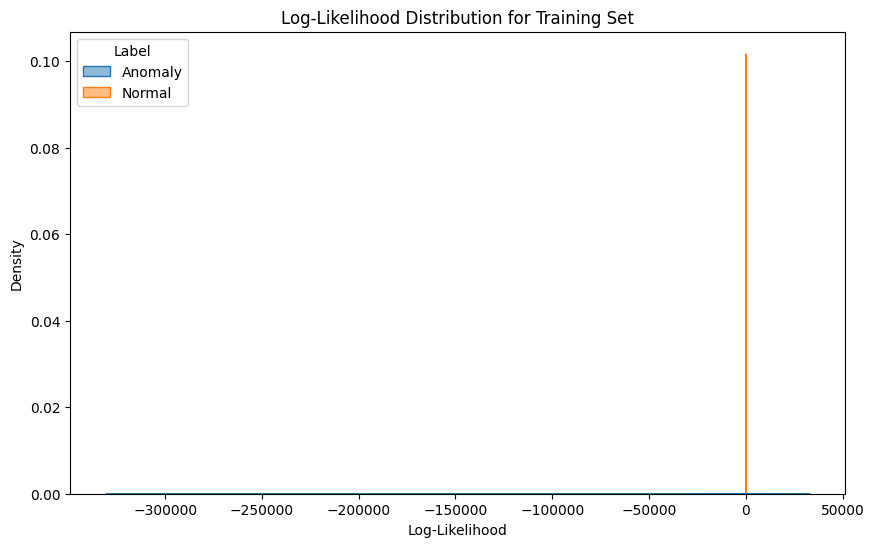


--- Evaluating on Validation Set (Final) ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Validation] Mean Normal Log-Likelihood: -760.2060
[Validation] Mean Anomaly Log-Likelihood: -10728.3320


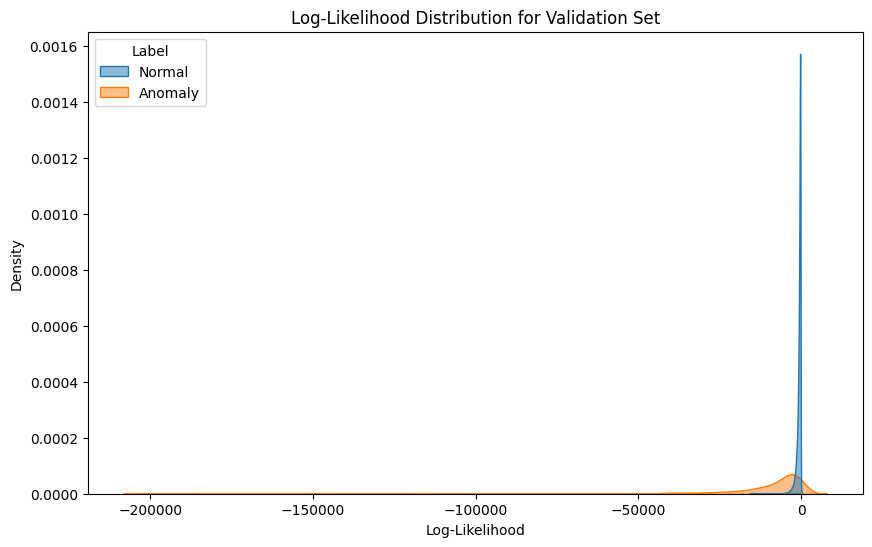


--- Evaluating Reloaded Model on Training Set ---


<ipython-input-43-07155253e757>:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded.load_state_dict(torch.load('model_gp_copula_likelihood_loss_margin_500_real_an

[Training Reloaded] Mean Normal Log-Likelihood: -155.6871
[Training Reloaded] Mean Anomaly Log-Likelihood: -35935.4805


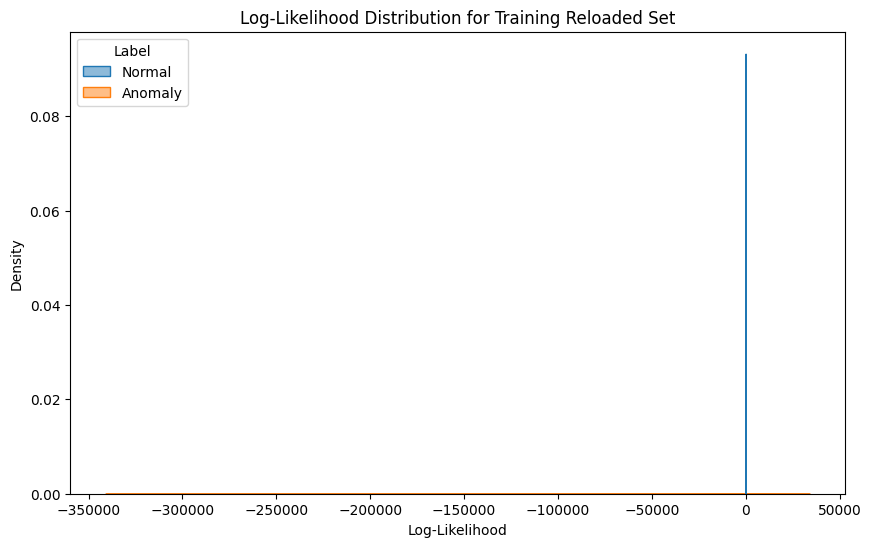


--- Evaluating Reloaded Model on Validation Set ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Validation Reloaded] Mean Normal Log-Likelihood: -760.2060
[Validation Reloaded] Mean Anomaly Log-Likelihood: -10728.3320


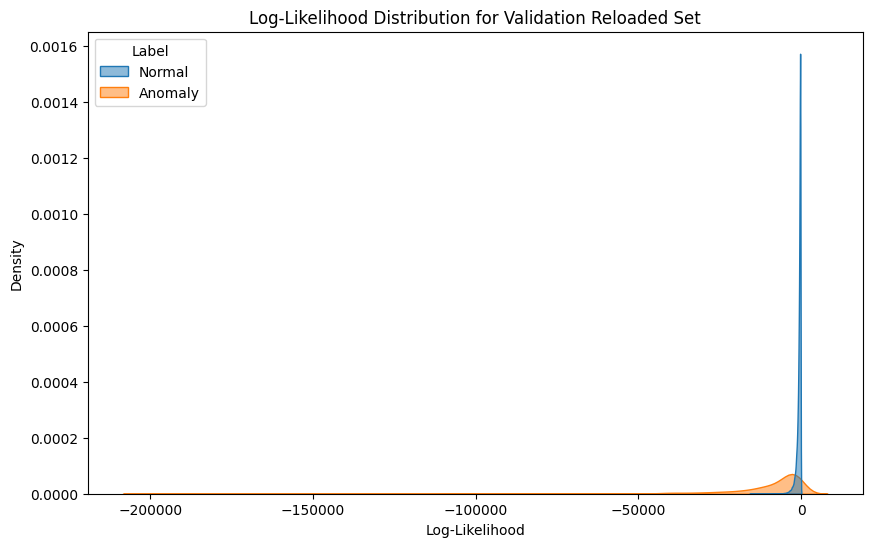

AUC-ROC Values for Each Epoch:
[0.8818894967862977, 0.8818894967862977, 0.9093225364203597, 0.9093225364203597, 0.8987502679732153, 0.8987502679732153, 0.885661404008371, 0.885661404008371, 0.8967769941489143, 0.8967769941489143, 0.9213568770820271, 0.9213568770820271, 0.9145069245784562, 0.9145069245784562, 0.9199461126803138, 0.9199461126803138, 0.9200811768273138, 0.9200811768273138, 0.9244088581451906, 0.9244088581451906, 0.9291278132952735, 0.9291278132952735, 0.9327180285603454, 0.9327180285603454, 0.9357354201396528, 0.9357354201396528, 0.9322828654679409, 0.9322828654679409, 0.9342540218568272, 0.9342540218568272, 0.9338625993336008, 0.9338625993336008, 0.9332420477125016, 0.9332420477125016, 0.9328042307677106]
F1 Scores for Each Epoch:
[]
Accuracy Values for Each Epoch:
[0.94109, 0.94109, 0.96164, 0.96164, 0.94954, 0.94954, 0.95759, 0.95759, 0.96104, 0.96104, 0.96348, 0.96348, 0.96386, 0.96386, 0.96323, 0.96323, 0.96071, 0.96071, 0.96308, 0.96308, 0.96585, 0.96585, 0.96773, 0

<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

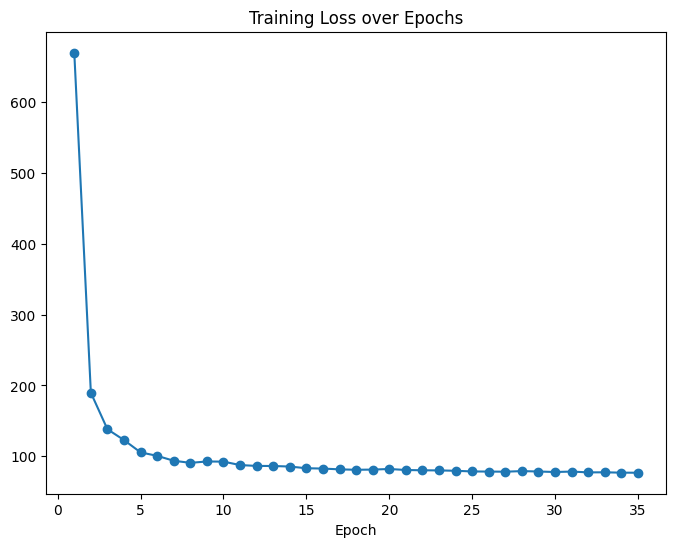

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau


num_epochs = 35
epoch_losses = []
val_metrics_history = []


epoch_losses = []


# Define scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

best_f1 = 0.0
patience_counter = 0
patience = 10  # Number of epochs to wait before stopping


epoch_losses = []
best_f1 = 0.0
patience_counter = 0
patience = 10

auc_roc_values = []  # <-- Added to store AUC-ROC values for each epoch
f_1_scores = []
accuracy_values = []
precision_values = []
recall_values = []

try:
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (padded_x1, padded_x2, labels, x1_mask, x2_mask) in enumerate(train_loader):
            padded_x1 = padded_x1.to(device)
            padded_x2 = padded_x2.to(device)
            labels = labels.to(device)
            x1_mask = x1_mask.to(device)
            x2_mask = x2_mask.to(device)

            optimizer.zero_grad()
            #log_likelihood = model(padded_x1, padded_x2, mask1=x1_mask, mask2=x2_mask)
            #loss = contrastive_loss(log_likelihood, labels, alpha=0.5, base_margin=10.0)

            ll_gaussian, ll_vine = model(padded_x1, padded_x2, mask1=x1_mask, mask2=x2_mask)
            loss = contrastive_loss(ll_gaussian, ll_vine, labels, alpha=0.5, base_margin=500.0)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

        # Validation every few epochs
        if epoch % 2 == 0:
            val_metrics = validate(model, val_loader, device)
            print(f"Validation Metrics @ Epoch {epoch}: {val_metrics}")


         # Store AUC-ROC value for this epoch
        auc_roc_values.append(val_metrics['auc_roc'])  # <-- Added this line
        #f_1_scores.append(val_metrics['f1_point'])
        accuracy_values.append(val_metrics['accuracy'])
        precision_values.append(val_metrics['precision'])
        recall_values.append(val_metrics['recall'])

        # Update the learning rate scheduler
        #scheduler.step(val_metrics['f1_point'])

except KeyboardInterrupt:
    print("Training interrupted. Saving model...")

# After training, evaluate before re-loading state
print("\n--- Evaluating on Training Set (Final) ---")
plot_log_likelihoods(model, train_loader, device, dataset_name="Training")

print("\n--- Evaluating on Validation Set (Final) ---")
plot_log_likelihoods(model, val_loader, device, dataset_name="Validation")

# Save the model
torch.save(model.state_dict(), 'model_gp_copula_likelihood_loss_margin_500_real_anomaly_30_percent_alpha_05_batch_128_emb_128.pth')

# Reload model with strict=True
model_loaded = AnomalyTransformer(input_dim=input_dim, model_dim=model_dim, num_heads=num_heads, num_layers=num_layers, dropout=dropout).to(device)
model_loaded.load_state_dict(torch.load('model_gp_copula_likelihood_loss_margin_500_real_anomaly_30_percent_alpha_05_batch_128_emb_128.pth'), strict=True)
model_loaded.eval()

# Check again after reloading
print("\n--- Evaluating Reloaded Model on Training Set ---")
plot_log_likelihoods(model_loaded, train_loader, device, dataset_name="Training Reloaded")

print("\n--- Evaluating Reloaded Model on Validation Set ---")
plot_log_likelihoods(model_loaded, val_loader, device, dataset_name="Validation Reloaded")

print("AUC-ROC Values for Each Epoch:")
print(auc_roc_values)
print("F1 Scores for Each Epoch:")
print(f_1_scores)
print("Accuracy Values for Each Epoch:")
print(accuracy_values)

print("Precision Values for Each Epoch:")
print(precision_values)
print("Recall Values for Each Epoch:")
print(recall_values)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel


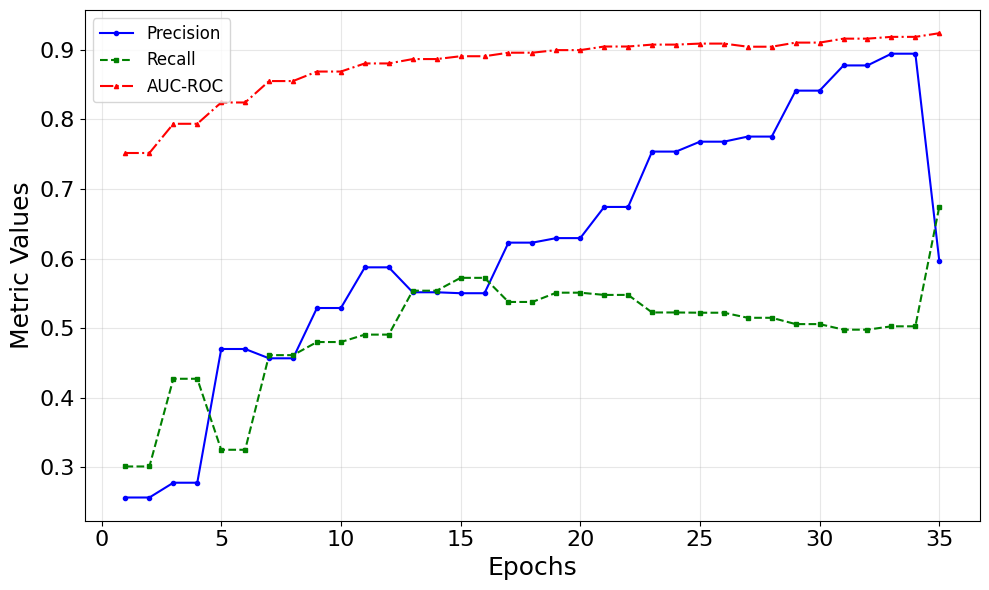

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for precision, recall, and AUC-ROC (replace these with your actual values)
epochs = np.arange(1, 36)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(epochs, precision_values, label='Precision', color='blue', marker='o', markersize=3, linestyle='-')
plt.plot(epochs, recall_values, label='Recall', color='green', marker='s', markersize=3, linestyle='--')
plt.plot(epochs, auc_roc_values, label='AUC-ROC', color='red', marker='^', markersize=3, linestyle='-.')

# Add titles and labels
#plt.title('Performance Metrics Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Metric Values', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(alpha=0.3)

# Add a legend
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Load the saved state_dict, ignoring missing keys
model.load_state_dict(torch.load('model_gp_copula_likelihood_loss_margin_500_real_anomaly_30_percent_alpha_05_batch_128_emb_128.pth'), strict=False)

<ipython-input-45-6ae890472c99>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_gp_copula_likelihood_loss_margin_500_real_anomaly_30

<All keys matched successfully>

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Training] Mean Normal Log-Likelihood: -42.6980
[Training] Mean Anomaly Log-Likelihood: -4862.3848


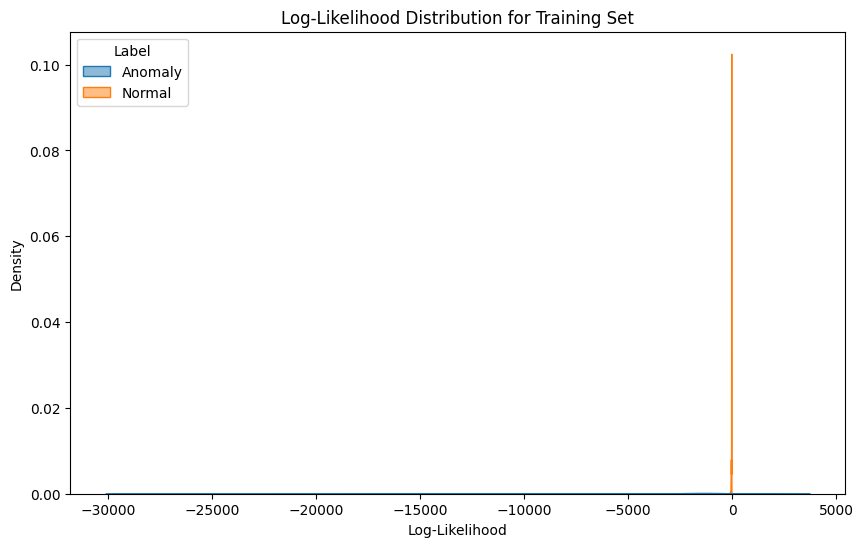

In [ ]:
# Plot for Training Set
plot_log_likelihoods(model, train_loader, device, dataset_name="Training")

# Plot for Validation Set
#plot_log_likelihoods(model, val_loader, device, dataset_name="Validation")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Validation] Mean Normal Log-Likelihood: -77117.7266
[Validation] Mean Anomaly Log-Likelihood: -1812141.0000


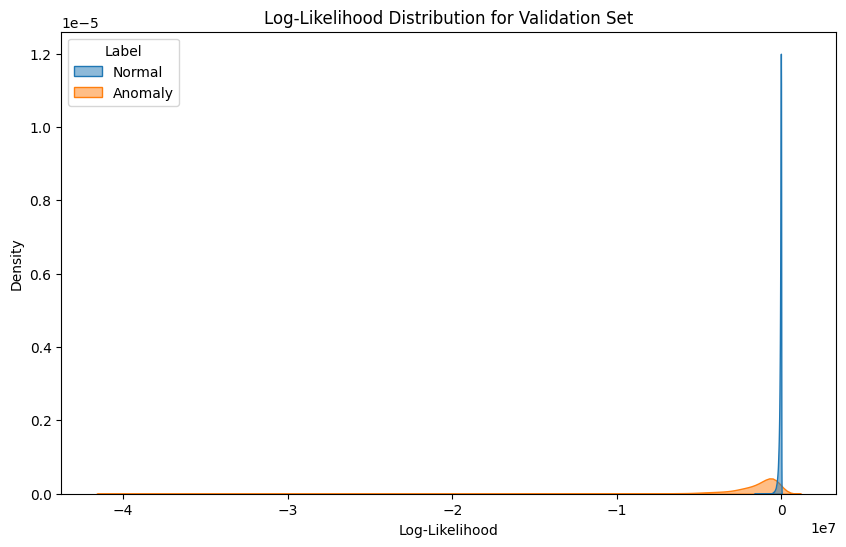

In [ ]:
# Plot for Validation Set
plot_log_likelihoods(model, val_loader, device, dataset_name="Validation")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Test] Mean Normal Log-Likelihood: -169.9399
[Test] Mean Anomaly Log-Likelihood: -819.9731


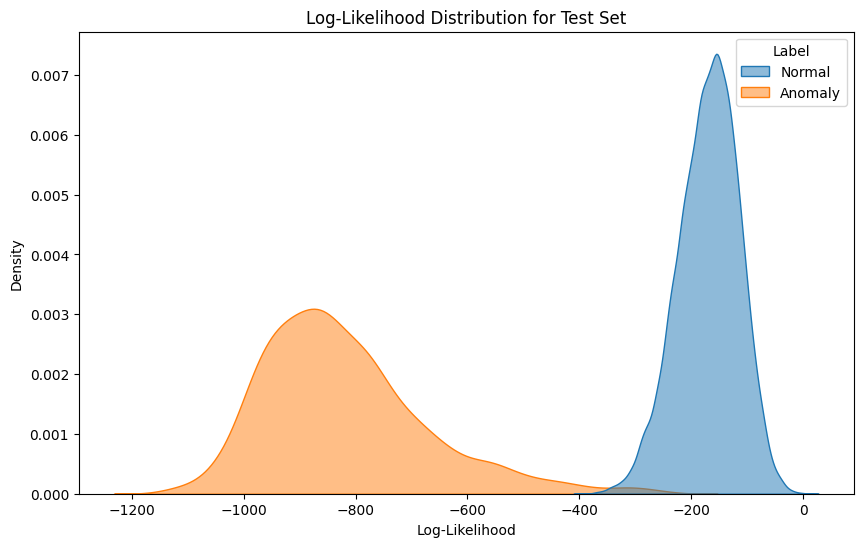

In [ ]:
# Plot for Validation Set
plot_log_likelihoods(model, test_loader, device, dataset_name="Test")

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

def visualize_latent_space(model, loader, device, dataset_name="Dataset"):
    """
    This function visualizes the latent space by extracting embeddings from the model
    for each batch in 'loader'. We'll handle 3 batch-size scenarios:
      1) 5 items: (x1, x2, labels, x1_mask, x2_mask)
      2) 3 items: (x1, x2, labels)
      3) 2 items: (features, labels)
    We'll assume the model has a method 'get_embeddings(x1, x2, mask1, mask2)'
    that returns an embedding (e.g. shape (batch_size, embed_dim)).
    """

    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import torch

    model.eval()

    all_embeddings = []
    all_labels     = []

    with torch.no_grad():
        for batch in loader:
            if len(batch) == 5:
                # (padded_x1, padded_x2, batch_labels, x1_mask, x2_mask)
                padded_x1, padded_x2, batch_labels, x1_mask, x2_mask = batch

                padded_x1 = padded_x1.to(device, dtype=torch.float32)
                padded_x2 = padded_x2.to(device, dtype=torch.float32)
                batch_labels = batch_labels.to(device)
                x1_mask = x1_mask.to(device)
                x2_mask = x2_mask.to(device)

                # We'll call some method get_embeddings() if your model has it
                embeddings = model.get_embeddings(padded_x1, padded_x2, mask1=x1_mask, mask2=x2_mask)

            elif len(batch) == 3:
                # (padded_x1, padded_x2, batch_labels)
                padded_x1, padded_x2, batch_labels = batch

                padded_x1 = padded_x1.to(device, dtype=torch.float32)
                padded_x2 = padded_x2.to(device, dtype=torch.float32)
                batch_labels= batch_labels.to(device)

                embeddings = model.get_embeddings(padded_x1, padded_x2)

            elif len(batch) == 2:
                # (features, labels)
                features, batch_labels = batch

                features = features.to(device, dtype=torch.float32)
                batch_labels= batch_labels.to(device)

                # If model expects two inputs, pass features twice
                # or adapt if your model uses a single input in get_embeddings
                embeddings = model.get_embeddings(features, features)

            else:
                raise ValueError(f"Unexpected number of items in batch: {len(batch)}")

            # Convert embeddings + labels to CPU
            emb_np = embeddings.cpu().numpy()
            lbl_np = batch_labels.cpu().numpy()

            all_embeddings.append(emb_np)
            all_labels.append(lbl_np)

    # Concat all
    all_embeddings = np.concatenate(all_embeddings, axis=0)  # shape (total_samples, embed_dim)
    all_labels     = np.concatenate(all_labels,     axis=0)  # shape (total_samples,)

    # Suppose we do a 2D visualization via e.g. TSNE
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=0)
    emb_2d = tsne.fit_transform(all_embeddings)

    # Plot
    plt.figure(figsize=(8,6))
    # separate normal vs anomaly for coloring
    normal_mask  = (all_labels == 0)
    anomaly_mask = (all_labels == 1)

    plt.scatter(emb_2d[normal_mask,0],  emb_2d[normal_mask,1],  c='blue',  alpha=0.5, label='Normal')
    plt.scatter(emb_2d[anomaly_mask,0], emb_2d[anomaly_mask,1], c='red',   alpha=0.5, label='Anomaly')

    plt.title(f"Latent Space Visualization - {dataset_name}")
    plt.legend()
    plt.show()


<ipython-input-45-23dcfd278168>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('anomaly_detection_model_08_per_min_max.pth'), strict=Fals

FileNotFoundError: [Errno 2] No such file or directory: 'anomaly_detection_model_08_per_min_max.pth'

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


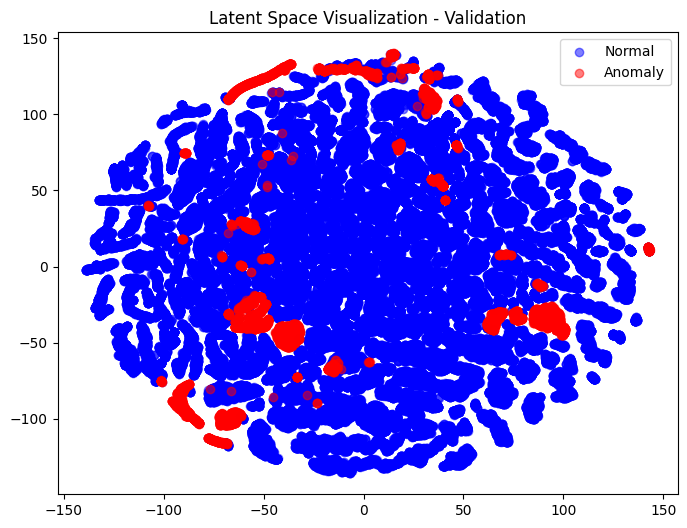

In [ ]:
# Visualize the latent space for the training set
#visualize_latent_space(model, train_loader, device, dataset_name="Train")

# Visualize the latent space for the test set
visualize_latent_space(model, val_loader, device, dataset_name="Validation")
